In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(12,5)})
%load_ext autoreload
%autoreload 2 

In [133]:
import sys
import os
import itertools
import re
from functools import cmp_to_key
sys.path.append(os.path.abspath('../modules'))
from hard_rules import candidate_cookies, versions_key, compare_versions

In [151]:
data = pd.read_parquet("../Data/10K_HH.parquet")

In [152]:
data = data[data["maid"]==7]

In [153]:
data["time"].apply(lambda t: (t.year, t.month)).value_counts().sort_index()

(2021, 12)         56
(2022, 1)         365
(2022, 2)          22
(2022, 12)    1329060
(2023, 1)     1402187
(2023, 2)      669026
Name: time, dtype: int64

In [154]:
data = data[data["time"] >= pd.to_datetime("2022-12-01")]

In [155]:
pattern = re.compile(r'^\d+(\.\d+)*$')
data = data[data.osversion.str.match(pattern)]

In [156]:
pattern = re.compile(r'^\d+(\.\d+)*$')
data = data[data.browserversion.str.match(pattern)]

In [34]:
grouped = data.groupby(['hh_id', 'iiqid']).agg({'time': ['min', 'max']})

In [35]:
grouped["lifespan"] = grouped[("time", "max")] - grouped[("time", "min")]

In [36]:
grouped["lifespan"] = grouped["lifespan"].apply(lambda t: t.days)

In [31]:
data.head()

,timestamp,filename,iiqid,hh_id,maid,partner_id,ip,iscellip,cellispid,domain,...,model,os,osversion,browser,advertisedbrowser,browserversion,type,is_best_ip,time,is_hh
0,1675608908952,HH_M,m9gT9WQU45,2RrCJATsw0,1,27,1645518178,False,-390920904,1744930452,...,iphone,ios,15.7.3,safari,iOS WebView,15.7.3,smartphone,False,2023-02-05 14:55:08.952,True
1,1675599499567,HH_M,m9gT9WQU45,2RrCJATsw0,1,27,1645518178,False,-390920904,1744930452,...,iphone,ios,15.7.3,safari,iOS WebView,15.7.3,smartphone,False,2023-02-05 12:18:19.567,True
2,1675551883837,HH_M,m9gT9WQU45,2RrCJATsw0,3,27,1800261306,True,-727330291,-395787423,...,iphone,ios,14.2,safari,iOS WebView,14.2,smartphone,False,2023-02-04 23:04:43.837,True
3,1675532057269,HH_M,m9gT9WQU45,2RrCJATsw0,1,27,1645518178,False,-390920904,1744930452,...,iphone,ios,15.7.3,safari,iOS WebView,15.7.3,smartphone,False,2023-02-04 17:34:17.269,True
4,1675527517327,HH_M,m9gT9WQU45,2RrCJATsw0,4,27,1800261306,True,-727330291,-395787423,...,iphone,ios,14.2,safari,iOS WebView,14.2,smartphone,False,2023-02-04 16:18:37.327,True


In [37]:
grouped.lifespan.max()

84

<Axes: xlabel='lifespan', ylabel='Count'>

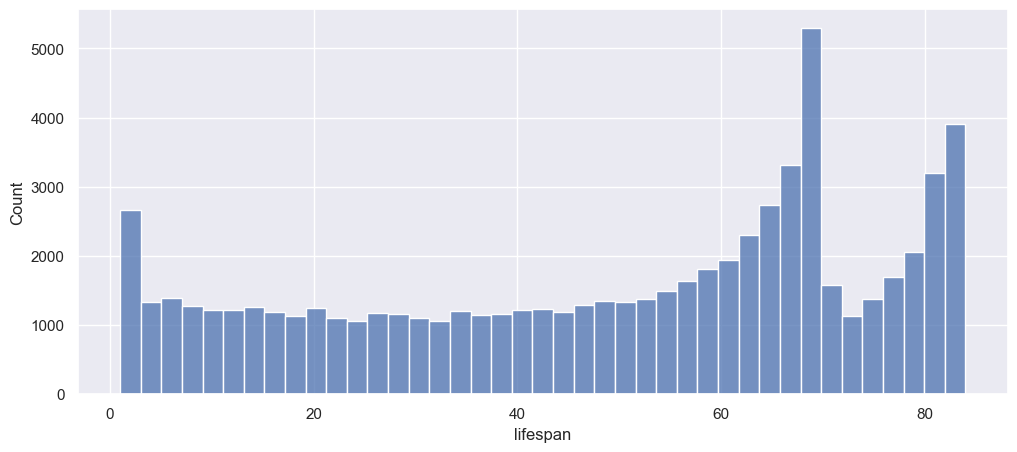

In [45]:
sns.histplot(data=grouped[grouped["lifespan"]>0], x="lifespan")

<BarContainer object of 2 artists>

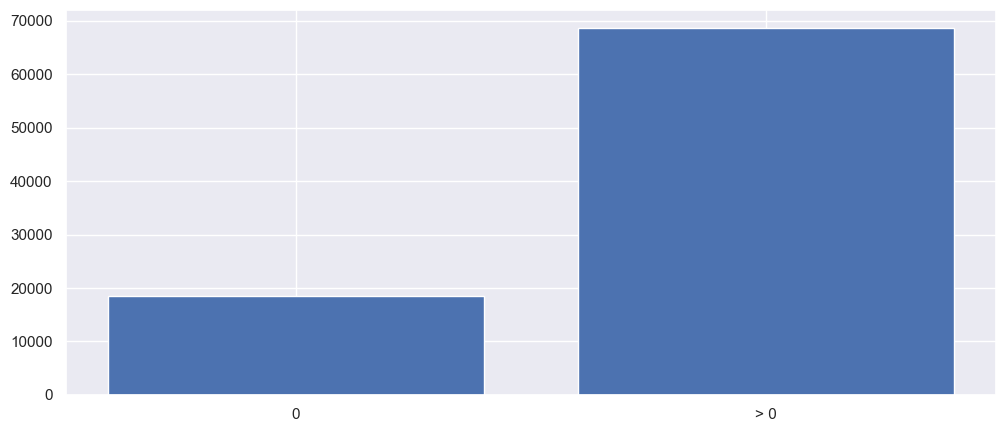

In [50]:
plt.bar(["0","> 0"], 
        [len(grouped[grouped["lifespan"]==0]), len(grouped[grouped["lifespan"]>0])])

In [51]:
grouped.head()

time                         lifespan
                                          min                     max         
hh_id      iiqid                                                              
008lj1AMI8 6MILYBoI9P 2022-12-06 20:30:42.973 2023-02-03 17:29:52.687       58
           UVg62Vt8Va 2022-12-04 06:04:54.956 2023-02-03 22:48:53.120       61
           WATS0P8zVm 2023-01-04 09:04:24.973 2023-02-08 09:39:50.615       35
           X93J3N7vAC 2022-12-02 03:20:07.416 2023-01-02 06:31:36.724       31
           eIVlRbV49r 2023-01-06 00:40:28.200 2023-02-09 03:11:06.924       34

In [89]:
one_row = grouped[grouped["lifespan"] > 60].sample(1)
one_row

time                         lifespan
                                         min                     max         
hh_id     iiqid                                                              
418078058 Bcjz15r0Ms 2022-12-08 05:04:58.662 2023-02-20 04:49:41.883       73

In [90]:
one_cookie = one_row.index.get_level_values(1).values[0]

In [91]:
one_cookie

'Bcjz15r0Ms'

In [92]:
one_cookie_data = data[data["iiqid"]==one_cookie]

In [93]:
one_cookie_data.browser.value_counts()

chrome mobile    37
Name: browser, dtype: int64

In [94]:
most_common_brw = one_cookie_data.browser.mode().iloc[0]

In [95]:
one_cookie_data = one_cookie_data[one_cookie_data["browser"]==most_common_brw]

<Axes: xlabel='time', ylabel='browserversion'>

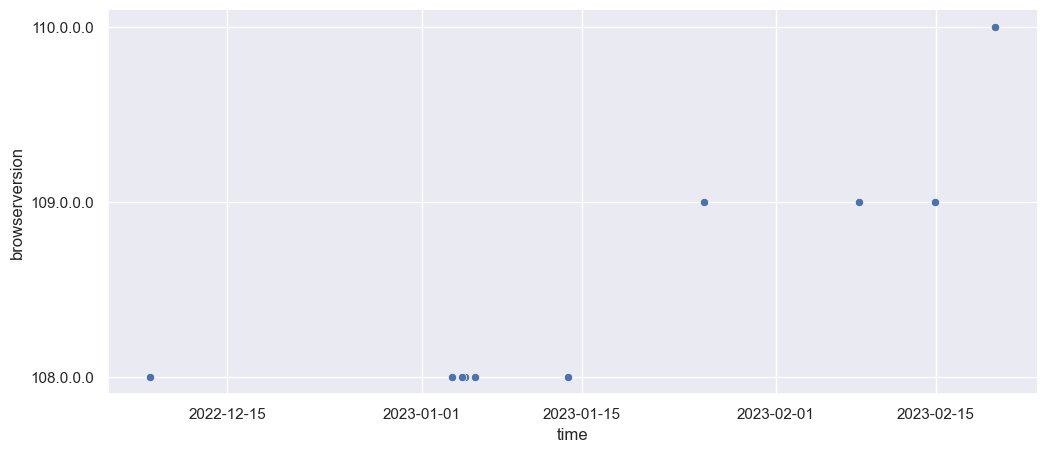

In [96]:
sns.scatterplot(data=one_cookie_data, x="time", y="browserversion")

## Lets try to find how many error are they

For a given cookie:
Go over all of its apearesnces and see if the browserversion stays consistent.
Lets strat by a simple "yes/no" test.

In [99]:
one_cookie_data = one_cookie_data.sort_values(by="time")

In [108]:
one_cookie_data["prev_browserversion"] = one_cookie_data["browserversion"].shift(1).fillna("0.0.0.0")

In [115]:
all(np.vectorize(compare_versions)(one_cookie_data['prev_browserversion'], one_cookie_data['browserversion']) <= 0)

True

In [116]:
def has_no_errors(cookie, df=data):
    one_cookie_data = df[df["iiqid"]==cookie].sort_values(by="time")
    one_cookie_data["prev_browserversion"] = one_cookie_data["browserversion"].shift(1).fillna("0.0.0.0")
    one_cookie_data["prev_osversion"] = one_cookie_data["osversion"].shift(1).fillna("0")
    browser_consistency = all(np.vectorize(compare_versions)(one_cookie_data['prev_browserversion'], one_cookie_data['browserversion']) <= 0)
    os_consistency = all(np.vectorize(compare_versions)(one_cookie_data['osversion'], one_cookie_data['osversion']) <= 0)
    return browser_consistency and os_consistency

In [119]:
has_no_errors(one_cookie)

True

In [121]:
# fraction_of_bad_cookies = sum(has_no_errors(c) for c in data["iiqid"].unique()) / len(data)

In [122]:
# "{0.0}".foramt(fraction_of_bad_cookies)

In [157]:
data.sort_values(by="time", inplace=True)
# grouped_cookies = data.groupby(["hh_id", "iiqid"])

In [158]:
data['prev_osversion'] = data.groupby(['hh_id', 'iiqid'])['osversion'].shift(1).fillna("0")
data['prev_browserversion'] = data.groupby(['hh_id', 'iiqid'])['browserversion'].shift(1).fillna("0.0.0.0")

In [159]:
full_valid_rows = data[(np.vectorize(compare_versions)(data['osversion'], 
                                                         data['prev_osversion']) >= 0)
                       & (np.vectorize(compare_versions)(data['browserversion'], 
                                                               data['prev_browserversion']) >= 0)]

In [ ]:
# comparisons = [compare_versions(browser_ver1, browser_ver2)
#                    for browser_ver1, browser_ver2 in zip(grouped_cookies['browserversion'].iloc[:-1], grouped_cookies['browserversion'].iloc[1:])]                                             

In [164]:
ok_rows_counts = full_valid_rows.groupby(['hh_id', 'iiqid']).size()

In [165]:
total_rows_counts = data.groupby(['hh_id', 'iiqid']).size()

In [166]:
all_ok = ok_rows_counts.eq(total_rows_counts)

In [167]:
all_ok

hh_id       iiqid     
008lj1AMI8  6MILYBoI9P     True
            UVg62Vt8Va     True
            WATS0P8zVm     True
            mXwL7QCw5O     True
            vjNRSKwlH4     True
                          ...  
zygR659Gbx  zU35cTjEsV    False
zzyXvF318v  0UXCVZvWch    False
            26UHp1Gc7Y     True
            2oWL7w8Na8     True
            uo36TXLVcg    False
Length: 48506, dtype: bool

In [170]:
result = pd.concat([total_rows_counts, all_ok], axis=1)
result.columns = ['instances','ok'] 

In [171]:
result

instances     ok
hh_id      iiqid                       
008lj1AMI8 6MILYBoI9P         66   True
           UVg62Vt8Va         41   True
           WATS0P8zVm        156   True
           mXwL7QCw5O         51   True
           vjNRSKwlH4         28   True
...                          ...    ...
zygR659Gbx zU35cTjEsV        595  False
zzyXvF318v 0UXCVZvWch         40  False
           26UHp1Gc7Y         46   True
           2oWL7w8Na8          2   True
           uo36TXLVcg        126  False

[48506 rows x 2 columns]

<Axes: xlabel='ok', ylabel='count'>

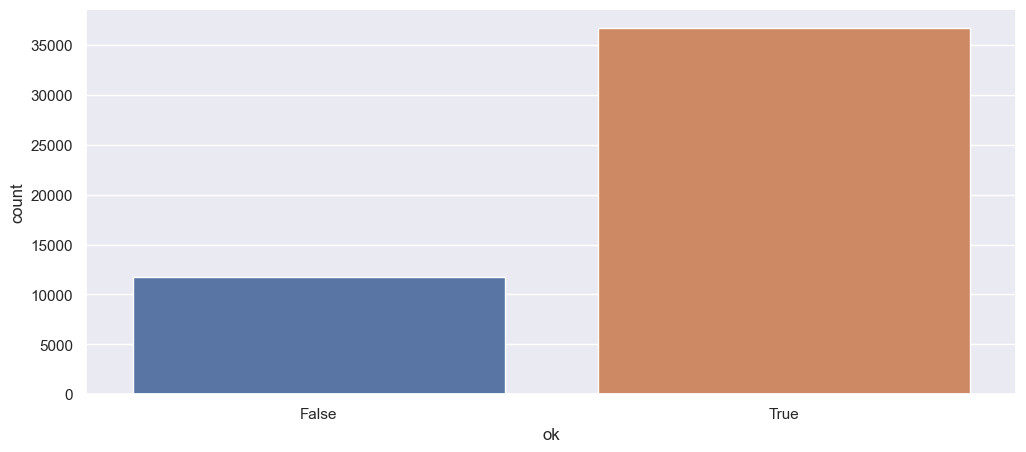

In [172]:
sns.countplot(data=result, x='ok')

In [ ]:
sns.boxplot(data=result, x='ok', y='instances')